In [1]:
import tensorflow as tf
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import random
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [2]:
input_dir = "/content/drive/MyDrive/FESB/images"
target_dir = "/content/drive/MyDrive/FESB/masks"

img_width = 512
img_height = 512
batch_size = 10

In [3]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

In [4]:
len(input_img_paths)

400

In [5]:
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".bmp") and not fname.startswith(".")
    ]
)

In [6]:
len(target_img_paths)

400

In [7]:
for input_path, target_path in zip(input_img_paths, target_img_paths):
    print(input_path, "|", target_path)

/content/drive/MyDrive/FESB/images/src_1.jpg | /content/drive/MyDrive/FESB/masks/gt_1.bmp
/content/drive/MyDrive/FESB/images/src_10.jpg | /content/drive/MyDrive/FESB/masks/gt_10.bmp
/content/drive/MyDrive/FESB/images/src_100.jpg | /content/drive/MyDrive/FESB/masks/gt_100.bmp
/content/drive/MyDrive/FESB/images/src_101.jpg | /content/drive/MyDrive/FESB/masks/gt_101.bmp
/content/drive/MyDrive/FESB/images/src_102.jpg | /content/drive/MyDrive/FESB/masks/gt_102.bmp
/content/drive/MyDrive/FESB/images/src_103.jpg | /content/drive/MyDrive/FESB/masks/gt_103.bmp
/content/drive/MyDrive/FESB/images/src_104.jpg | /content/drive/MyDrive/FESB/masks/gt_104.bmp
/content/drive/MyDrive/FESB/images/src_105.jpg | /content/drive/MyDrive/FESB/masks/gt_105.bmp
/content/drive/MyDrive/FESB/images/src_106.jpg | /content/drive/MyDrive/FESB/masks/gt_106.bmp
/content/drive/MyDrive/FESB/images/src_107.jpg | /content/drive/MyDrive/FESB/masks/gt_107.bmp
/content/drive/MyDrive/FESB/images/src_108.jpg | /content/drive/My

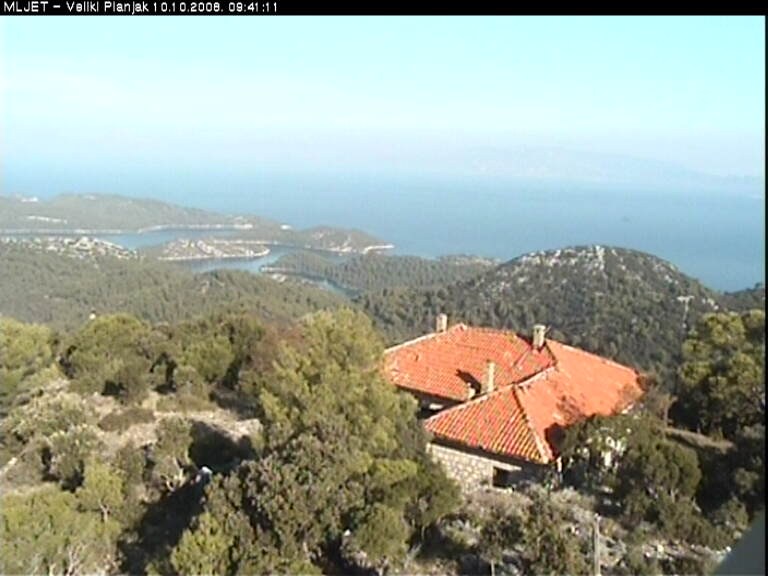

In [8]:
display(Image(filename=input_img_paths[399]))

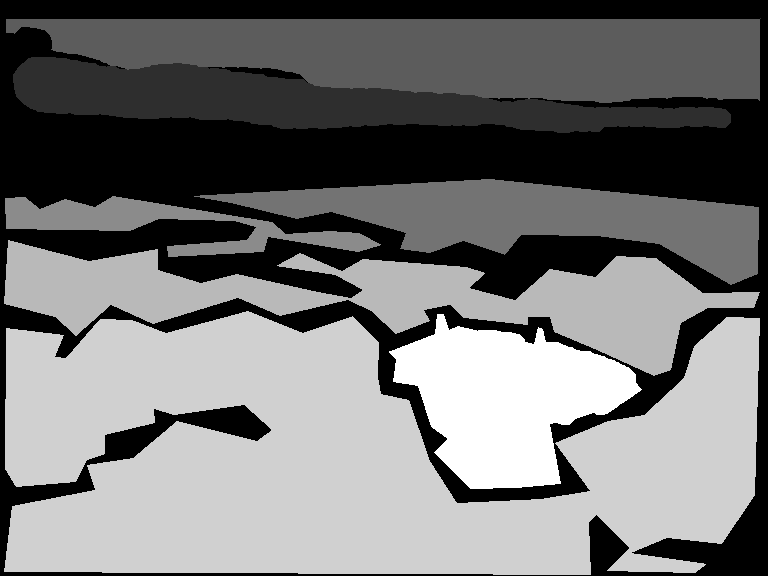

In [9]:
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[399]))
display(img)

In [10]:
class FESB_MLID(keras.utils.Sequence):
    """ Helper to iterate over the data (as Numpy arrays). """

    def __init__(self, batch_size, img_width, img_height, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """ Returns tuple (input, target) correspond to batch #idx. """

        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size, img_height, img_width, 3), dtype=np.float32)
        for image_index, path in enumerate(batch_input_img_paths):
            img = load_img(path)
            x_img = img_to_array(img)
            x_img = resize(x_img, (img_height, img_width, 3), mode='constant')
            x[image_index] = x_img

        y = np.zeros((self.batch_size, img_height, img_width, 3), dtype=np.float32)
        for target_index, path in enumerate(batch_target_img_paths):
            target_img = img_to_array(load_img(path))
            target_img = resize(target_img, (img_height, img_width, 3), mode='constant')
            y[target_index] = target_img / 255
        
        return x, y

In [11]:
import random

val_samples = 20
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = FESB_MLID(
    batch_size, img_width, img_height, train_input_img_paths, train_target_img_paths
)
val_gen = FESB_MLID(
    batch_size, img_width, img_height, val_input_img_paths, val_target_img_paths)

In [12]:
type(train_gen)

__main__.FESB_MLID

In [13]:
type(train_gen[0])

tuple

In [14]:
type(train_gen[0][0])

numpy.ndarray

In [15]:
type(train_gen[0][1])

numpy.ndarray

In [16]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding="same")(input_tensor)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding="same")(x)
    x = Activation("relu")(x)
    return x

In [17]:
def get_model(input_img, n_filters=16):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [18]:
input_img = Input((img_height, img_width, 3), name='img')
model = get_model(input_img, n_filters=16)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        activation[0][0]                 
______________________________________________________________________________________________

In [19]:
callbacks = [
    ModelCheckpoint('model-proba2.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [20]:
results = model.fit(train_gen, batch_size=batch_size, epochs=10, callbacks=callbacks,
                    validation_data=(val_gen))

Epoch 1/10
38/38 [==============================] - 1060s 28s/step - loss: 1.9359 - accuracy: 0.1978 - val_loss: 0.6477 - val_accuracy: 0.3270

Epoch 00001: val_loss improved from inf to 0.64772, saving model to model-proba2.h5
Epoch 2/10
38/38 [==============================] - 1016s 27s/step - loss: 0.6630 - accuracy: 0.2232 - val_loss: 0.6406 - val_accuracy: 0.3399

Epoch 00002: val_loss improved from 0.64772 to 0.64064, saving model to model-proba2.h5
Epoch 3/10
38/38 [==============================] - 1020s 27s/step - loss: 0.6570 - accuracy: 0.2412 - val_loss: 0.6302 - val_accuracy: 0.3345

Epoch 00003: val_loss improved from 0.64064 to 0.63025, saving model to model-proba2.h5
Epoch 4/10
38/38 [==============================] - 1026s 27s/step - loss: 0.6449 - accuracy: 0.2278 - val_loss: 0.6374 - val_accuracy: 0.3100

Epoch 00004: val_loss did not improve from 0.63025
Epoch 5/10
38/38 [==============================] - 1023s 27s/step - loss: 0.6325 - accuracy: 0.2476 - val_loss: 

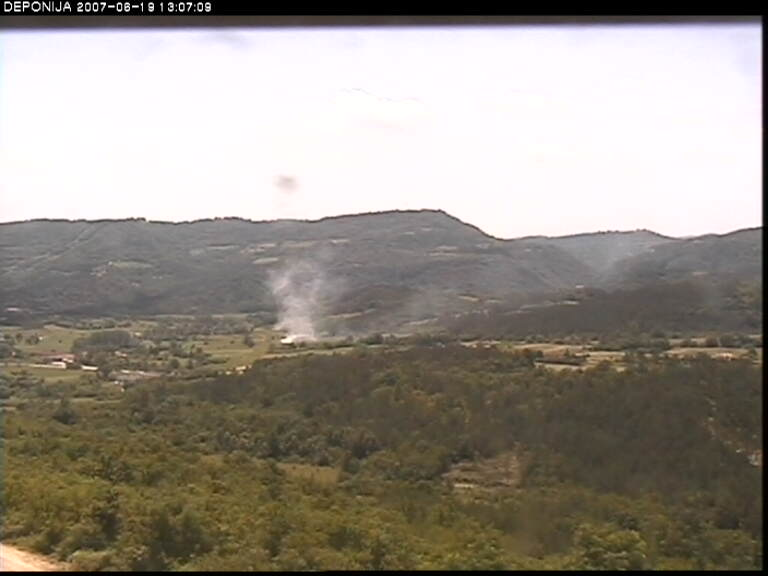

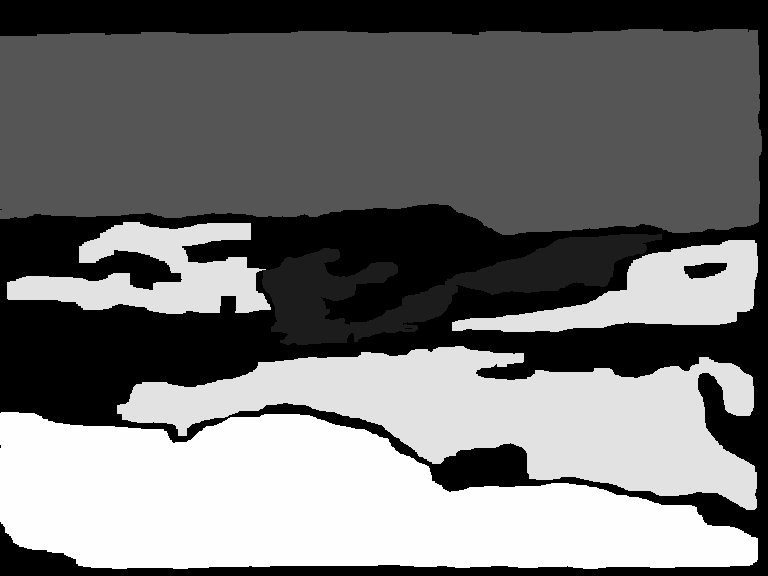

In [23]:
val_gen = FESB_MLID(
    batch_size, img_width, img_height, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

i = 19

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

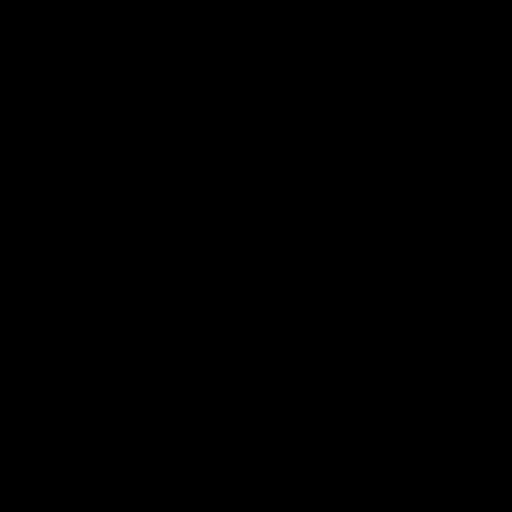

In [24]:
# Display mask predicted by our model
display_mask(i)

img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)